In [10]:
#Import libraries for cleaning and visualizing data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Define the path to your data file
data_path = r'C:\Users\derek\OneDrive\Documents\Capstone\steam-indie-success\data\steam_indie_games_balanced.csv'

# Load the data into a DataFrame
df = pd.read_csv(data_path)

# Preview the first few rows to confirm successful loading
print(df.head(10))

# Display the data types for each column
print(df.dtypes)

# Use .info() to get more detailed information
print(df.info())



     AppID                             Game Name  Release Date  \
0  2193070                      Returning To Mia  Oct 27, 2023   
1   328940                          The Deer God  Feb 27, 2015   
2  2738050                  エスカレーター |  Escalator   Jan 6, 2024   
3  1634150  Behind the Frame: The Finest Scenery  Aug 25, 2021   
4   391260                         Labyronia RPG  Aug 14, 2015   
5   311400                     OCEAN CITY RACING  Nov 14, 2014   
6  1329600                               Karting  Apr 15, 2021   
7  1245430                          Golden Light  Mar 11, 2022   
8   314180                           Deathsmiles  Mar 10, 2016   
9  2482440              Leap up no Justu: Double  Dec 21, 2023   

                             Developer  \
0                        Inceton games   
1  Crescent Moon Games, Cinopt Studios   
2                              Toyasky   
3                 Silver Lining Studio   
4                         Labyrinthine   
5               OCR D

In [12]:
# Check for missing values
missing_values = df.isna().sum()
print(missing_values)

AppID                 0
Game Name             0
Release Date          0
Developer             0
Genres                0
Price ($)             0
Recommendations       0
Metacritic Score    255
dtype: int64


In [13]:
# Step 1: Convert 'Release Date' to datetime
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')

# Check for invalid dates
print(df['Release Date'].isna().sum())

# Step 2: Convert 'Price ($)' to numeric
df['Price ($)'] = pd.to_numeric(df['Price ($)'].str.replace('$', ''), errors='coerce')

# Check for invalid price entries
print(df['Price ($)'].isna().sum())

# Step 3: Handle missing values in 'Metacritic Score'
# Option 1: Fill missing values with the mean or median score
df['Metacritic Score'].fillna(df['Metacritic Score'].mean(), inplace=True)

# Step 4: Clean text data (e.g., strip extra whitespace)
df['Game Name'] = df['Game Name'].str.strip()
df['Developer'] = df['Developer'].str.strip()
df['Genres'] = df['Genres'].str.strip()

# Confirm the changes
print(df.head(10))
print(df.dtypes)


6
6
     AppID                             Game Name Release Date  \
0  2193070                      Returning To Mia   2023-10-27   
1   328940                          The Deer God   2015-02-27   
2  2738050                  エスカレーター |  Escalator   2024-01-06   
3  1634150  Behind the Frame: The Finest Scenery   2021-08-25   
4   391260                         Labyronia RPG   2015-08-14   
5   311400                     OCEAN CITY RACING   2014-11-14   
6  1329600                               Karting   2021-04-15   
7  1245430                          Golden Light   2022-03-11   
8   314180                           Deathsmiles   2016-03-10   
9  2482440              Leap up no Justu: Double   2023-12-21   

                             Developer  \
0                        Inceton games   
1  Crescent Moon Games, Cinopt Studios   
2                              Toyasky   
3                 Silver Lining Studio   
4                         Labyrinthine   
5               OCR Dev Team

C:\Users\derek\AppData\Local\Temp\ipykernel_146820\1464800596.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Metacritic Score'].fillna(df['Metacritic Score'].mean(), inplace=True)


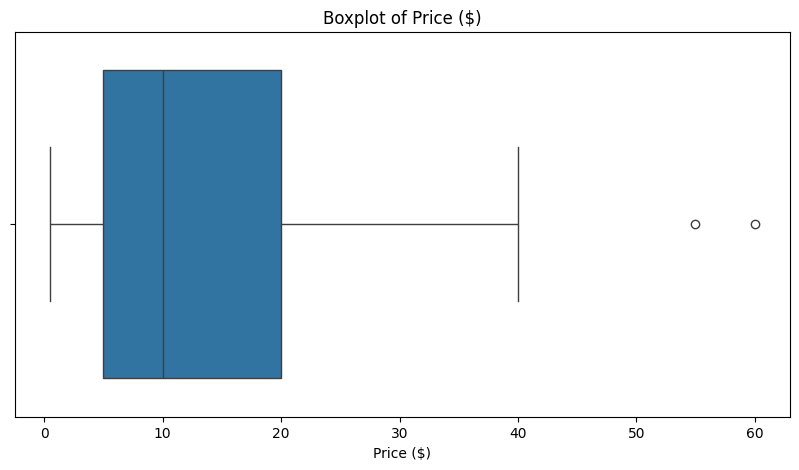

In [14]:
# Boxplot for Price ($)
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Price ($)')
plt.title('Boxplot of Price ($)')
plt.show()


Number of outliers in 'Price ($)': 2
           Game Name  Price ($)
29      Dude Fighter      59.99
176  Legendary Tales      54.99


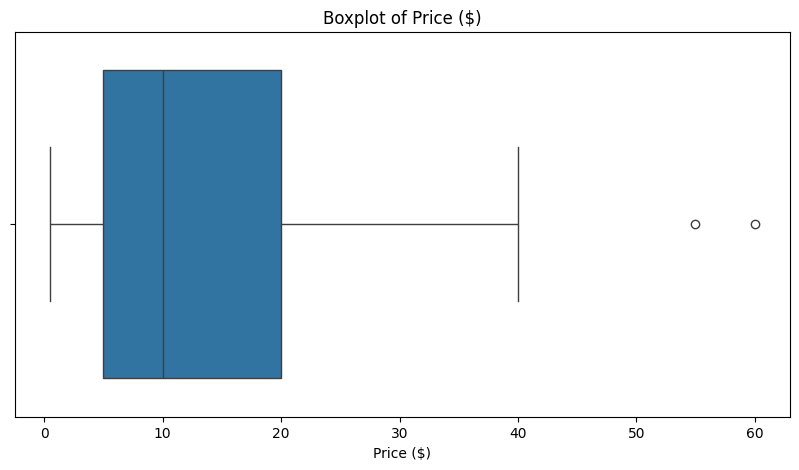

In [15]:
# Step: Identify Outliers for Price ($)
Q1 = df['Price ($)'].quantile(0.25)
Q3 = df['Price ($)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Finding the outliers
outliers = df[(df['Price ($)'] < lower_bound) | (df['Price ($)'] > upper_bound)]

# Display outliers
print("Number of outliers in 'Price ($)':", outliers.shape[0])
print(outliers[['Game Name', 'Price ($)']])

# Boxplot visualization
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Price ($)')
plt.title('Boxplot of Price ($)')
plt.show()

